#  <font color='#FFE15D'><b>💎 Coloring with GAN</b></font>
<img src="http://dl.howsam.org/Deep-Catalyst/rocket-200px.png" alt="Deep Catalyst"/>

Deep Catalyst Course [webpage](https://howsam.org/downloads/deep-catalyst/)

by Howsam AI Academy (www.howsam.org)

# 🔴 Environment Setup


### 🟠 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🔴 Install Libs

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.2 MB/s eta 0:00:00



# 🔴 Import Libs

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import autograd

import numpy as np
import pandas as pd

from pathlib import Path

import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from torchmetrics.aggregation import MeanMetric

from PIL import Image
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML

from tqdm import tqdm


# 🔴 Arguments

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

root = '/content/drive/MyDrive/coloring_with_gan/'
root_dir = Path(root)

data = '/content/coloring_dataset-v0.3/v0.3/processed'
data_dir = Path(data)
os.makedirs(data_dir, exist_ok=True)

model_path = root_dir / 'model'
output_path = root_dir / 'output'

os.makedirs(model_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

color_names = ['blue', 'brown', 'red', 'yellow', 'green']

img_size = 256
batch_size = 16
num_workers = 2
num_color_channels = 3

num_gen_filters = 64
num_disc_filters = 64

input_channels = 3
output_channels = 3

lr = 0.0002
lambda_ = 100

n_epochs = 80


# 🔴 Utils

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [ ]:
color_name_mapping = {color: idx for idx, color in enumerate(color_names)}
color_name_mapping

{'blue': 0, 'brown': 1, 'red': 2, 'yellow': 3, 'green': 4}

# 🔴 Dataset

In [ ]:
!unzip -q /content/drive/MyDrive/coloring_with_gan/coloring_dataset-v0.3.zip

In [ ]:
metadata_train_path = data_dir / 'train' / 'metadata.csv'
df_train = pd.read_csv(metadata_train_path)
display(df_train)

,input,target,hair,shirt
0,0001.bmp,0001.bmp,blue,blue
1,0001.bmp,0002.bmp,blue,brown
2,0001.bmp,0003.bmp,blue,red
3,0001.bmp,0004.bmp,blue,yellow
4,0001.bmp,0005.bmp,blue,green
...,...,...,...,...
470,0019.bmp,0471.bmp,green,blue
471,0019.bmp,0472.bmp,green,brown
472,0019.bmp,0473.bmp,green,red
473,0019.bmp,0474.bmp,green,yellow


In [ ]:
num_hair_colors = df_train['hair'].nunique()
num_shirt_colors = df_train['shirt'].nunique()
num_conditions = num_hair_colors + num_shirt_colors
num_hair_colors, num_shirt_colors, num_conditions

(5, 5, 10)

### 🟠 Custom Dataset

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, data_dir, phase, color_name_mapping, transform=None):

        self.data_dir = data_dir
        self.phase = phase
        self.transform = transform

        self.metadata = pd.read_csv(data_dir/ phase / 'metadata.csv')
        self.color_name_mapping = color_name_mapping

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        input_img_name = self.metadata.input[idx]
        target_img_name = self.metadata.target[idx]
        hair_color = self.color_name_mapping[self.metadata.hair[idx]]
        shirt_color = self.color_name_mapping[self.metadata.shirt[idx]]

        input_img_path = self.data_dir / self.phase / 'inputs' / input_img_name
        target_img_path = self.data_dir / self.phase / 'targets' / target_img_name

        input_img = T.ToTensor()(Image.open(input_img_path))
        target_img = T.ToTensor()(Image.open(target_img_path))

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img, hair_color, shirt_color

In [ ]:
transform = T.Compose([T.Resize(img_size, antialias=True),
                       T.CenterCrop(img_size)])

In [ ]:
train_set = ColorizationDataset(data_dir, 'train', color_name_mapping, transform)
test_set = ColorizationDataset(data_dir, 'test', color_name_mapping, transform)
len(train_set), len(test_set)

(475, 200)

In [ ]:
input_image, target_image, hair_color, shirt_color = train_set[40]
input_image.shape, target_image.shape, hair_color, shirt_color

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]), 3, 0)

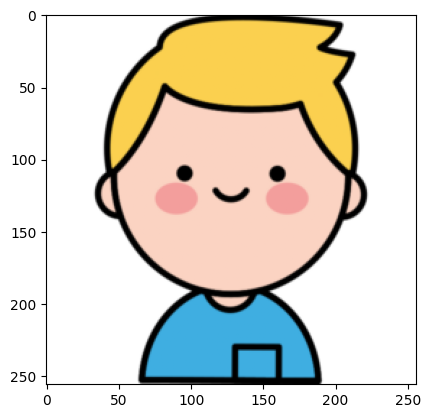

In [ ]:
plt.imshow(target_image.permute(1, 2, 0));

### 🟠 Dataloader

In [ ]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_set, batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

In [ ]:
input_img, target_img, hair_color, shirt_color = next(iter(train_loader))
input_img.shape, target_img.shape, hair_color, shirt_color

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 3, 256, 256]),
 tensor([1, 2, 4, 1, 0, 4, 0, 3, 2, 3, 4, 4, 0, 3, 1, 0]),
 tensor([0, 3, 0, 1, 2, 4, 0, 4, 4, 2, 3, 2, 4, 1, 1, 1]))

### 🟠 Visualization

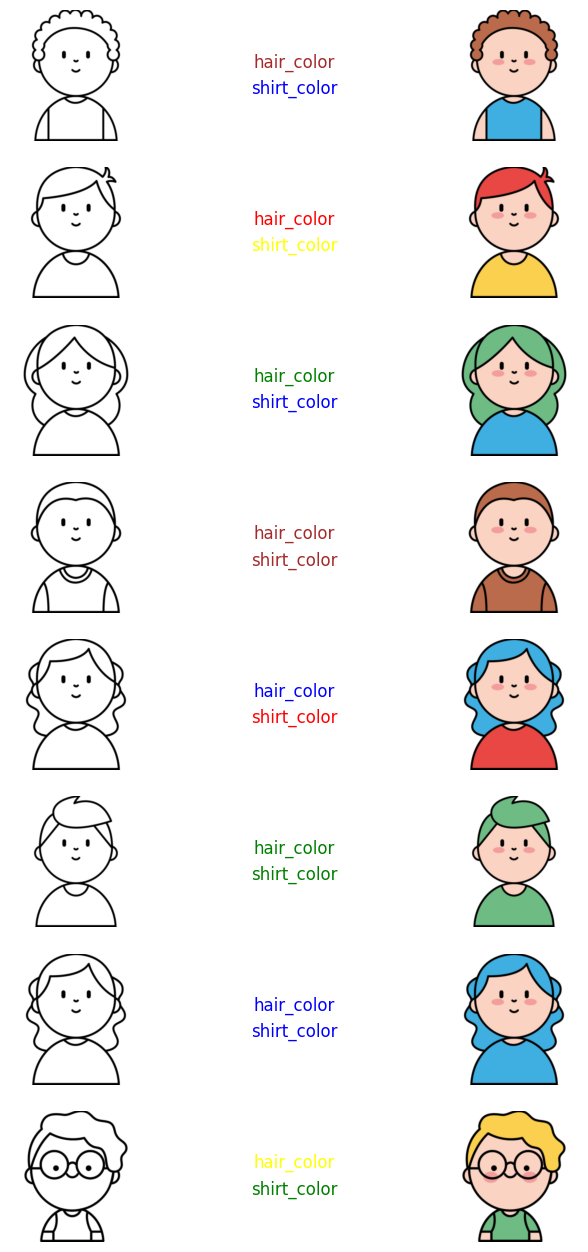

In [ ]:
hair_color_name = [list(color_name_mapping.keys())[idx] for idx in hair_color]
shirt_color_name = [list(color_name_mapping.keys())[idx] for idx in shirt_color]

fig, axs = plt.subplots(8, 3, figsize=(8, 16))

for i in range(8):
    # plot input image
    axs[i, 0].imshow(input_img[i].permute(1, 2, 0))
    axs[i, 0].axis('off')

    # hair_color & shirt_color text
    axs[i, 1].text(0.5, 0.6, 'hair_color', color=hair_color_name[i % len(hair_color_name)],
                  horizontalalignment='center', verticalalignment='center', fontsize=12)
    axs[i, 1].text(0.5, 0.4, 'shirt_color', color=shirt_color_name[i % len(shirt_color_name)],
                  horizontalalignment='center', verticalalignment='center',fontsize=12)
    axs[i, 1].axis('off')

    # plot target image
    axs[i, 2].imshow(target_img[i].permute(1, 2, 0))
    axs[i, 2].axis('off')

plt.show()

# 🔴 Model

### 🟠 Generator

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batch_norm:
            x = self.batch_norm(x)
        x = self.activation(x)
        return x

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.5) if dropout else None
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.deconv(x)
        x = self.batch_norm(x)
        if self.dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

In [ ]:
def normal_init(m, mean, std):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, mean, std)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, num_hair_colors, num_shirt_colors, ngf=64):
        super(Generator, self).__init__()

        # Encoder blocks
        self.encoder1 = EncoderBlock(input_channels + num_hair_colors + num_shirt_colors, ngf, batch_norm=False)
        self.encoder2 = EncoderBlock(ngf, ngf * 2)
        self.encoder3 = EncoderBlock(ngf * 2, ngf * 4)
        self.encoder4 = EncoderBlock(ngf * 4, ngf * 8)
        self.encoder5 = EncoderBlock(ngf * 8, ngf * 8)
        self.encoder6 = EncoderBlock(ngf * 8, ngf * 8)
        self.encoder7 = EncoderBlock(ngf * 8, ngf * 8)
        self.encoder8 = EncoderBlock(ngf * 8, ngf * 8)

        # Decoder blocks
        self.decoder1 = DecoderBlock(ngf * 8, ngf * 8, dropout=True)
        self.decoder2 = DecoderBlock(ngf * 8 * 2, ngf * 8, dropout=True)
        self.decoder3 = DecoderBlock(ngf * 8 * 2, ngf * 8, dropout=True)
        self.decoder4 = DecoderBlock(ngf * 8 * 2, ngf * 8)
        self.decoder5 = DecoderBlock(ngf * 8 * 2, ngf * 4)
        self.decoder6 = DecoderBlock(ngf * 4 * 2, ngf * 2)
        self.decoder7 = DecoderBlock(ngf * 2 * 2, ngf)
        self.decoder8 = nn.ConvTranspose2d(ngf * 2, 3, kernel_size=4, stride=2, padding=1)

        # Tanh activation for the final output
        self.tanh = nn.Tanh()

        # Initialize weights
        self.apply(lambda m: normal_init(m, 0.0, 0.02))

    def forward(self, input, hair_color, shirt_color):
        # One-hot encoding for hair and shirt colors
        hair_color_onehot = F.one_hot(hair_color, 5).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, input.size(2), input.size(3))
        shirt_color_onehot = F.one_hot(shirt_color, 5).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, input.size(2), input.size(3))

        # Concatenate input with one-hot encoded colors
        input = torch.cat([input, hair_color_onehot, shirt_color_onehot], dim=1)

        # Encoder blocks
        enc1 = self.encoder1(input)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)
        enc6 = self.encoder6(enc5)
        enc7 = self.encoder7(enc6)
        enc8 = self.encoder8(enc7)

        # Decoder blocks with skip connections
        dec1 = F.dropout(self.decoder1(F.relu(enc8)), 0.5, training=True)
        dec1 = torch.cat([dec1, enc7], 1)

        dec2 = F.dropout(self.decoder2(F.relu(dec1)), 0.5, training=True)
        dec2 = torch.cat([dec2, enc6], 1)

        dec3 = F.dropout(self.decoder3(F.relu(dec2)), 0.5, training=True)
        dec3 = torch.cat([dec3, enc5], 1)

        dec4 = self.decoder4(F.relu(dec3))
        dec4 = torch.cat([dec4, enc4], 1)

        dec5 = self.decoder5(F.relu(dec4))
        dec5 = torch.cat([dec5, enc3], 1)

        dec6 = self.decoder6(F.relu(dec5))
        dec6 = torch.cat([dec6, enc2], 1)

        dec7 = self.decoder7(F.relu(dec6))
        dec7 = torch.cat([dec7, enc1], 1)

        # Final decoder block with 3 output channels
        dec8 = self.decoder8(F.relu(dec7))
        output = self.tanh(dec8)

        return output


In [ ]:
generator = Generator(input_channels, output_channels, num_hair_colors, num_shirt_colors, num_gen_filters).to(device)
generator

Generator(
  (encoder1): EncoderBlock(
    (conv): Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (encoder2): EncoderBlock(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (encoder3): EncoderBlock(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (encoder4): EncoderBlock(
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (encoder5): EncoderBlock(
    (conv): Conv2d(512, 512

In [ ]:
sketch_img = torch.randn(batch_size, 3, 256, 256)
hair_color_idx = torch.randint(num_hair_colors, (batch_size,))
shirt_color_idx = torch.randint(num_shirt_colors, (batch_size,))

output_img = generator(sketch_img.to(device), hair_color_idx.to(device), shirt_color_idx.to(device))
print("Output Shape:", output_img.shape)

Output Shape: torch.Size([16, 3, 256, 256])


### 🟠 Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_color_channels, ndf, num_hair_colors, num_shirt_colors):
        super(Discriminator, self).__init__()
        self.num_hair_colors = num_hair_colors
        self.num_shirt_colors = num_shirt_colors

        self.D = nn.Sequential(
            nn.Conv2d(num_color_channels * 2 + 10, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # size: [batch_size, ndf, 128, 128]

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True), # size: [batch_size, ndf*2, 64, 64]

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True), # size: [batch_size, ndf*4, 32, 32]

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True), # size: [batch_size, ndf*8, 16, 16]

            nn.Conv2d(ndf * 8, 1, 16, 1, 0, bias=False),  # size: [batch_size, 1, 1, 1]

            nn.Flatten(1),
            nn.Sigmoid(),
        )

    def forward(self, sketch_img, target_img, hair_color, shirt_color):

        hair_color_onehot = F.one_hot(hair_color,
                                      self.num_hair_colors).unsqueeze(-1).unsqueeze(-1).repeat(1, 1,
                                                                                               sketch_img.size(2),
                                                                                               sketch_img.size(3))
        shirt_color_onehot = F.one_hot(shirt_color,
                                       self.num_shirt_colors).unsqueeze(-1).unsqueeze(-1).repeat(1, 1,
                                                                                                 sketch_img.size(2),
                                                                                                 sketch_img.size(3))

        img_cat = torch.cat((sketch_img, target_img, hair_color_onehot, shirt_color_onehot), dim=1)
        return self.D(img_cat)

In [ ]:
discriminator = Discriminator(num_color_channels, num_disc_filters, num_hair_colors, num_shirt_colors)
discriminator

Discriminator(
  (D): Sequential(
    (0): Conv2d(16, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Sig

In [ ]:
sketch_img = torch.randn(batch_size, 3, 256, 256)
target_img = torch.randn(batch_size, 3, 256, 256)
hair_color_idx = torch.randint(num_hair_colors, (batch_size,))
shirt_color_idx = torch.randint(num_shirt_colors, (batch_size,))

output = discriminator(sketch_img, target_img, hair_color_idx, shirt_color_idx)
print(output.shape)

torch.Size([16, 1])


# 🔴 Loss & Optimizers

In [ ]:
loss_fn = nn.BCELoss()
loss = nn.L1Loss()

In [ ]:
generator = Generator(input_channels, output_channels, num_hair_colors, num_shirt_colors, num_gen_filters).to(device)
discriminator = Discriminator(num_color_channels, num_disc_filters, num_hair_colors, num_shirt_colors).to(device)

In [ ]:
G_optimizer = optim.Adam(generator.parameters(), lr, betas=(0.5, 0.99))
D_optimizer = optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.99))

# 🔴 Train

In [ ]:
loss_D_hist, loss_G_hist = [], []

In [ ]:
for epoch in range(n_epochs):
  loss_discriminator, loss_generator = MeanMetric(), MeanMetric()

  with tqdm(train_loader, unit="batch") as tepoch:
    for batch_idx, (input, target, hair_color, shirt_color) in enumerate(tepoch):
      tepoch.set_description(f'Epoch {epoch}')
      #----------------------------------------------------------------------
      # Discriminator
      #----------------------------------------------------------------------
      discriminator.zero_grad()

      # real data
      real_input = input.requires_grad_().to(device)
      real_target = target.requires_grad_().to(device)
      hair_color = hair_color.to(device)
      shirt_color = shirt_color.to(device)
      real_conditional = torch.ones(batch_size, 1, device=device)

      # real -> D
      D_output = discriminator(real_input, real_target, hair_color, shirt_color)
      D_loss = loss_fn(D_output, real_conditional)
      D_loss.backward(retain_graph=True)

      # noise & fake label
      fake_hair_color = torch.randint(num_hair_colors, (batch_size,)).to(device)
      fake_shirt_color = torch.randint(num_shirt_colors, (batch_size,)).to(device)
      fake_conditional = torch.zeros(batch_size, 1, device=device)

      # fake data -> G -> D
      generated_img = generator(real_input, fake_hair_color, fake_shirt_color)
      G_output = discriminator(real_input, generated_img, fake_hair_color, fake_shirt_color)

      G_loss = loss_fn(G_output, fake_conditional)
      G_loss.backward()

      # total loss D
      D_loss = G_loss + D_loss

      # optimization
      D_optimizer.step()

      #----------------------------------------------------------------------
      # Generator
      #----------------------------------------------------------------------
      generator.zero_grad()

      real_conditional = torch.ones(batch_size, 1).to(device)

      # noise -> G -> D
      generated_img = generator(real_input, fake_hair_color, fake_shirt_color)
      output = discriminator(real_input, generated_img, fake_hair_color, fake_shirt_color)


      # total loss generator
      gen_loss = loss_fn(output, real_conditional)
      gen_loss = gen_loss + lambda_ * loss(generated_img, real_target)

      # optimization
      gen_loss.backward()
      G_optimizer.step()

      loss_discriminator.update(D_loss.item(), weight=len(real_conditional))
      loss_generator.update(gen_loss.item(), weight=len(real_conditional))

      tepoch.set_postfix(loss_D=loss_discriminator.compute().item(), loss_G=loss_generator.compute().item())

      if batch_idx % 100 == 0:
        with torch.no_grad():
          generator.eval()
          outputs = generator(real_input,
                              torch.randint(num_hair_colors, (batch_size,)).to(device),
                              torch.randint(num_shirt_colors, (batch_size,)).to(device))
          save_image(outputs, f'{output_path}/ep{epoch:03d}.png', normalize=True)
          generator.train()

    loss_D_hist.append(loss_discriminator.compute().item())
    loss_G_hist.append(loss_generator.compute().item())


Epoch 79: 100%|██████████| 29/29 [00:23<00:00,  1.23batch/s, loss_D=1.62, loss_G=7.64]


In [ ]:
torch.save(generator, f'{model_path}/generator.pt')
torch.save(discriminator, f'{model_path}/discriminator.pt')

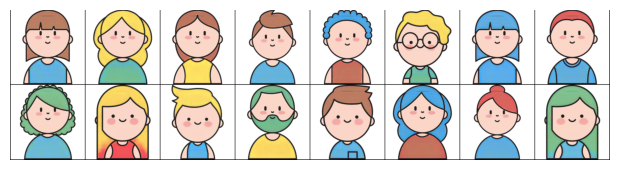

In [ ]:
# Visualization of Generator’s Progression
read_img_list = []
for img in glob.glob(f'{output_path}/*.png'):
  read_img_list.append(mpimg.imread(img))

fig = plt.figure(figsize=(6, 3))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.axis("off")
ims = [[plt.imshow(img, animated=True)] for img in read_img_list]
anim = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=50, blit=True)

anim.save(f'{output_path}/colorization_gan_anim.mp4')
HTML(anim.to_jshtml());

# 🔴 Plot

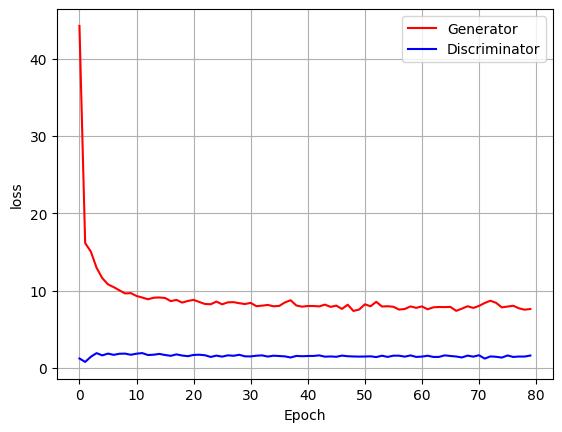

In [ ]:
plt.plot(range(n_epochs), loss_G_hist, 'r-', label='Generator')
plt.plot(range(n_epochs), loss_D_hist, 'b-', label='Discriminator')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend();

# 🔴 Evaluation

In [ ]:
generator_model = torch.load(f'{model_path}/generator.pt')
input_img_test, target_img_test, hair_color_test, shirt_color_test = next(iter(test_loader))

with torch.no_grad():
  generator_model.eval()
  generated_image = generator_model(input_img_test.to(device), hair_color_test.to(device), shirt_color_test.to(device))
  save_image(generated_image, f'{model_path}/gan_output.png')

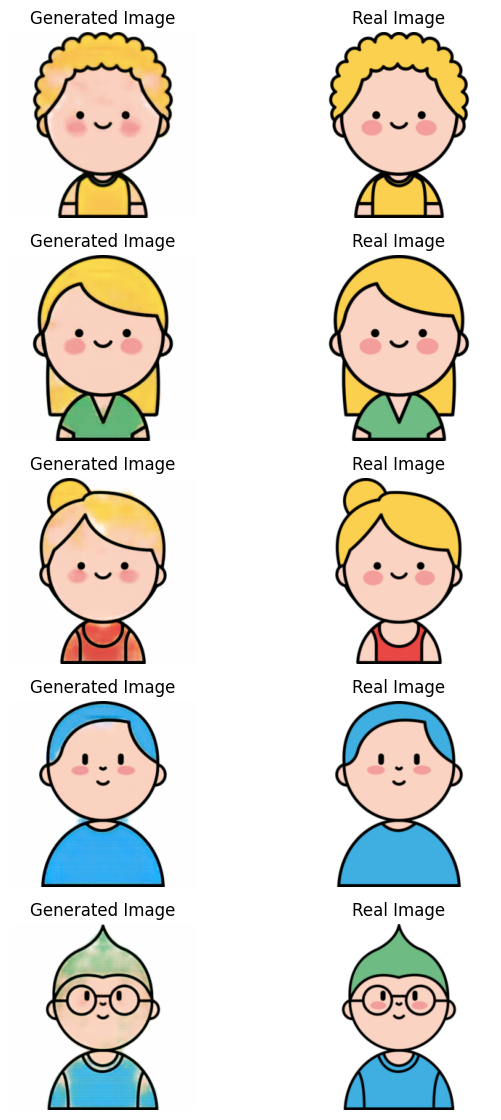

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(7, 14))

for i in range(5):
    # plot input image
    axs[i, 0].imshow(np.clip(generated_image[i].cpu().permute(1, 2, 0), 0, 255))
    axs[i, 0]. set_title('Generated Image')
    axs[i, 0].axis('off')

    # plot real image
    axs[i, 1].imshow(np.clip(target_img_test[i].cpu().permute(1, 2, 0), 0, 255))
    axs[i, 1]. set_title('Real Image')
    axs[i, 1].axis('off')

plt.show()